# Data Set Download and Basic Manipulations
Since the model uses both image transformers and text transformers it uses different data sets for these.For image processing, Imagenet and CIFAR10/100 datasets are used. For text processing Wikitext Dataset is used.




## Download CIFAR 10/100 Data

In [1]:
!pip install numpy matplotlib torch torchvision transformers
!pip install datasets
import torchvision
from torchvision import datasets, transforms

from torchvision import transforms

# Define the transformation: Convert to RGB and Resize all images to 224x224
transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize to 224x224
    transforms.Lambda(lambda x: x.convert("RGB")),  # Convert grayscale to RGB
    transforms.ToTensor()                      # Convert image to tensor
])

# Function to apply transformation
def apply_transform(batch):
    # Load image from bytes
    image = Image.open(io.BytesIO(batch["image"])).convert("RGB")
    batch["image"] = transform(image)  # Apply transformation pipeline
    return batch

# Download CIFAR-10
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Download CIFAR-100
cifar100_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
cifar100_test = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


100%|██████████| 170M/170M [00:18<00:00, 9.11MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


100%|██████████| 169M/169M [00:13<00:00, 12.7MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


## Download Imagenet Data
Since which Imagenet data is used is not specified, I download IMagenet Data 1000 k from Huggingface. Data is bigger compared CIFAR Data because of that data streaming technique is applied. In data streaming, data is downloaded in smaller chunks and model is trained on them then other chunk is downloaded.

Since model is run while downloding the data, sample run is taken on a simple Neural network.


In [ ]:
from huggingface_hub import login

login()  # This will prompt you to enter your Hugging Face token.

In [ ]:

from datasets import load_dataset

# Load ImageNet dataset in streaming mode
dataset = load_dataset("imagenet-1k", split="train", streaming=True)

# Apply the resize transformation to each image in the dataset
def apply_transform(batch):
    batch["image"] = transform(batch["image"])  # Apply the transform to each image
    return batch

# Apply the transformation using the `map` function
dataset = dataset.map(apply_transform)

In [ ]:
from torch.utils.data import DataLoader, IterableDataset

class HuggingFaceIterableDataset(IterableDataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __iter__(self):
        return iter(self.hf_dataset)  # Return an iterator over the Hugging Face streaming dataset

In [ ]:
# Wrap the Hugging Face dataset
hf_iterable_dataset = HuggingFaceIterableDataset(dataset)

# Create a DataLoader
loader = DataLoader(hf_iterable_dataset, batch_size=16, shuffle=False)  # Shuffling not directly supported in streaming mode


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple model (example)
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 224 * 224, 1000)  # Assuming ImageNet images resized to 224x224
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):
    for batch in loader:
        inputs, labels = batch["image"], batch["label"]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}, Loss: {loss.item()}")


KeyboardInterrupt: 

## Download Wikitext Data

In [ ]:

from datasets import load_dataset

# Load the WikiText-103 dataset
dataset_wiki = load_dataset("wikitext", "wikitext-103-v1")

# Results

## Fig *1*
For an attention head in
ViT trained on (a) CIFAR-10, and
(b) ImageNet, we plot the normalized spectra of WKW⊤
Q at initialization (in red), and of the learned
perturbations to WKW⊤
Q at different iterations (in green).

### For CIFAR10 data

In [4]:

import torch
from transformers import ViTForImageClassification, ViTConfig
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataloader = DataLoader(cifar10_train, batch_size=32, shuffle=True)

# Vision Transformer model
config = ViTConfig(image_size=224, num_labels=10, hidden_size=128, num_attention_heads=4)
model = ViTForImageClassification(config)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Function to compute singular values
def compute_singular_values(weight):
    # Use torch.linalg.svd for stability and modern compatibility
    u, s, v = torch.linalg.svd(weight)
    return s.cpu().detach().numpy()

# Define the layer and parameter names
layer_idx = 1  # Change to the layer index you want to analyze (e.g., 0, 1, 2,...)
key_weight_name = f"vit.encoder.layer.{layer_idx}.attention.attention.key.weight"
query_weight_name = f"vit.encoder.layer.{layer_idx}.attention.attention.query.weight"

# Save initial weights
initial_weights = {
    "key.weight": model.state_dict()[key_weight_name].clone().detach(),
    "query.weight": model.state_dict()[query_weight_name].clone().detach(),
}
iterations_to_track=[1,400,4000,24000]
singular_values=[]
num_epochs=16
iteration = 0  # Global iteration counter
# During training, extract current weights
for epoch in range(num_epochs):
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward and backward pass
        outputs = model(images)
        loss = loss_fn(outputs.logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment the global iteration counter
        iteration += 1

        # Track singular values at specific iterations
        if iteration in iterations_to_track:
            current_key = model.state_dict()[key_weight_name]
            current_query = model.state_dict()[query_weight_name]

            # Compute perturbation
            initial_key = initial_weights["key.weight"]
            initial_query = initial_weights["query.weight"]
            perturbation = (current_key @ current_query.T) - (initial_key @ initial_query.T)

            # Compute and store singular values
            singular_values.append(compute_singular_values(perturbation))
    print(f"Epoch {epoch+1}: Loss = {loss.item()}, Iteration= {iteration}")

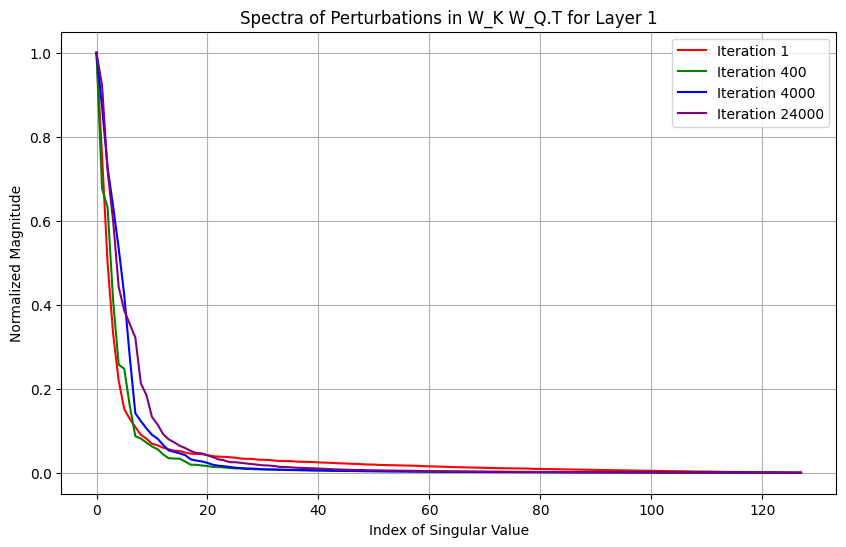

In [7]:
# Visualization
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'purple', 'orange']  # Adjust colors if needed

for idx, singulars in enumerate(singular_values):
    plt.plot(singulars / singulars[0], label=f"Iteration {iterations_to_track[idx]}", color=colors[idx])

plt.xlabel("Index of Singular Value")
plt.ylabel("Normalized Magnitude")
plt.title(f"Spectra of Perturbations in W_K W_Q.T for Layer {layer_idx}")
plt.legend()
plt.grid()
plt.show()

### For İmagenet Data
This run is not completed yet, as İmagenet data is bigger I need more time.

In [ ]:

import torch
from transformers import ViTForImageClassification, ViTConfig
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



# Vision Transformer model
config = ViTConfig(image_size=224, num_labels=1000, hidden_size=128, num_attention_heads=4)
model = ViTForImageClassification(config)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [ ]:
# Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Function to compute singular values
def compute_singular_values(weight):
    # Use torch.linalg.svd for stability and modern compatibility
    u, s, v = torch.linalg.svd(weight)
    return s.cpu().detach().numpy()

# Define the layer and parameter names
layer_idx = 1  # Change to the layer index you want to analyze (e.g., 0, 1, 2,...)
key_weight_name = f"vit.encoder.layer.{layer_idx}.attention.attention.key.weight"
query_weight_name = f"vit.encoder.layer.{layer_idx}.attention.attention.query.weight"

# Save initial weights
initial_weights = {
    "key.weight": model.state_dict()[key_weight_name].clone().detach(),
    "query.weight": model.state_dict()[query_weight_name].clone().detach(),
}
iterations_to_track=[1,400,4000,24000]
singular_values=[]
num_epochs=10
iteration = 0  # Global iteration counter
# During training, extract current weights
for epoch in range(num_epochs):
    for batch in loader:
        images, labels = batch["image"], batch["label"]
        images, labels = images.to(device), labels.to(device)

        # Forward and backward pass
        outputs = model(images)
        loss = loss_fn(outputs.logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment the global iteration counter
        iteration += 1

        # Track singular values at specific iterations
        if iteration in iterations_to_track:
            current_key = model.state_dict()[key_weight_name]
            current_query = model.state_dict()[query_weight_name]

            # Compute perturbation
            initial_key = initial_weights["key.weight"]
            initial_query = initial_weights["query.weight"]
            perturbation = (current_key @ current_query.T) - (initial_key @ initial_query.T)

            # Compute and store singular values
            singular_values.append(compute_singular_values(perturbation))
    print(f"Epoch {epoch+1}: Loss = {loss.item()}")

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'purple', 'orange']  # Adjust colors if needed

for idx, singulars in enumerate(singular_values):
    plt.plot(singulars / singulars[0], label=f"Iteration {iterations_to_track[idx]}", color=colors[idx])

plt.xlabel("Index of Singular Value")
plt.ylabel("Normalized Magnitude")
plt.title(f"Spectra of Perturbations in W_K W_Q.T for Layer {layer_idx}")
plt.legend()
plt.grid()
plt.show()

## Fig 2

Figure 2: (a) Loss versus rescaled time in the toy task of learning an attention head with diagonal
weights, for various initialization scales α. The loss curves converge as α → 0 to a curve with
stagewise loss plateaus and sharp decreases, as predicted by the theory; some stagewise learning
behavior is already clear with α = 0.01. (b) Each line shows the evolution of one of the entries
of diag(wQ)diag(wK) and diag(wV )diag(wO) over rescaled time, demonst

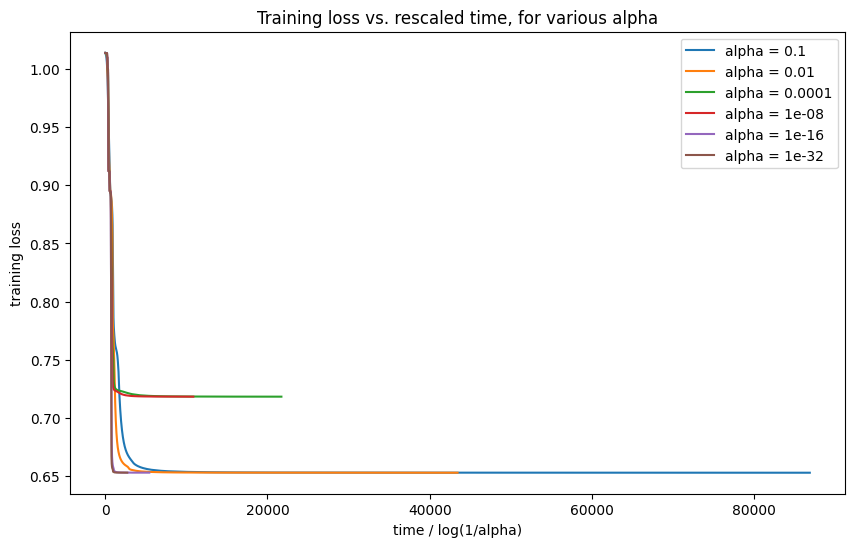

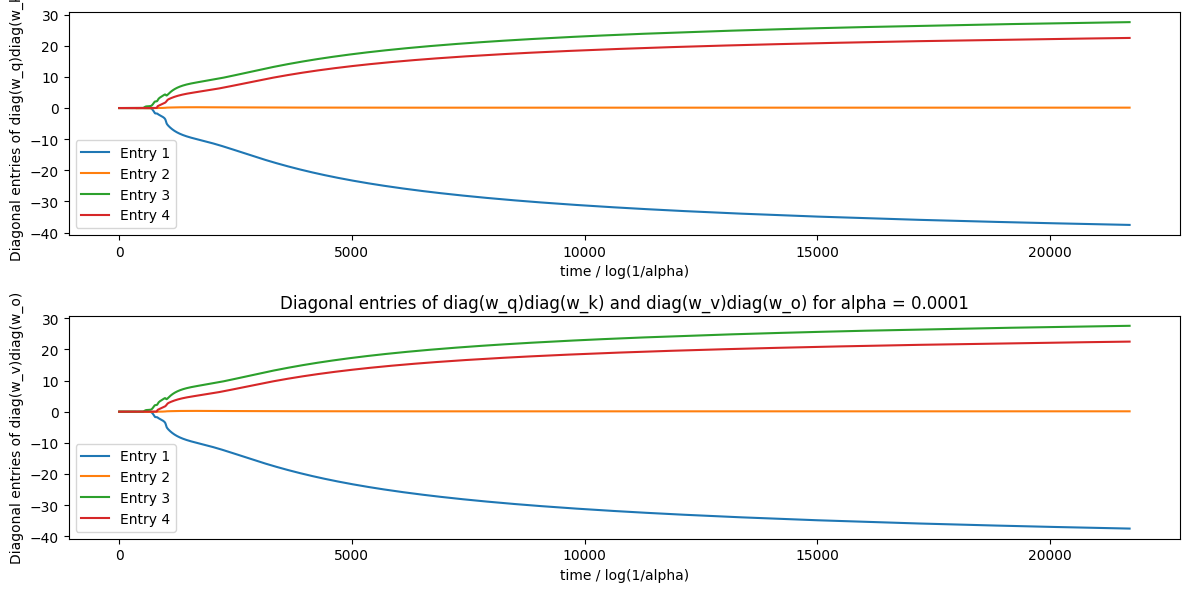

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Model Parameters
d_model = 4  # Small dimension for visualization
n_iters = 200000
alphas = [1e-1, 1e-2, 1e-4, 1e-8, 1e-16, 1e-32]
learning_rate = 0.1

# Synthetic Data
n_samples = 10
X = torch.randn(n_samples, d_model)
y = torch.randn(n_samples, d_model)  # Dummy target

# Loss function
loss_fn = nn.MSELoss()

# Storage for results
losses = []
diagonal_entries_evolution = {alpha: [] for alpha in alphas}

# Training loop for different alpha values
for alpha in alphas:
    # Initialize diagonal weights as leaf tensors
    w_k = torch.randn(d_model, requires_grad=True) * alpha
    w_q = torch.randn(d_model, requires_grad=True) * alpha
    w_v = torch.randn(d_model, requires_grad=True) * alpha
    w_o = torch.randn(d_model, requires_grad=True) * alpha

    # Ensure these tensors are leaves with requires_grad=True
    w_k = w_k.clone().detach().requires_grad_(True)
    w_q = w_q.clone().detach().requires_grad_(True)
    w_v = w_v.clone().detach().requires_grad_(True)
    w_o = w_o.clone().detach().requires_grad_(True)

    optimizer = torch.optim.SGD([w_k, w_q, w_v, w_o], lr=learning_rate)
    alpha_losses = []
    diag_evolution = []

    for t in range(n_iters):
        optimizer.zero_grad()

        # Compute model output using diagonal attention weights
        attention_scores = (X * w_q) @ (X * w_k).T
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attention_output = attention_weights @ (X * w_v) * w_o

        # Compute loss
        loss = loss_fn(attention_output, y)
        loss.backward()
        optimizer.step()

        # Store loss and diagonal entries
        alpha_losses.append(loss.item())
        diag_evolution.append(
            (w_k.detach().clone().numpy(), w_q.detach().clone().numpy())
        )

    losses.append((alpha, alpha_losses))
    diagonal_entries_evolution[alpha] = diag_evolution

# Plotting Figure 2(a): Loss vs. Rescaled Time
plt.figure(figsize=(10, 6))
for alpha, alpha_losses in losses:
    rescaled_time = [t / torch.log(torch.tensor(1 / alpha)).item() for t in range(n_iters)]
    plt.plot(rescaled_time, alpha_losses, label=f"alpha = {alpha}")
plt.xlabel("time / log(1/alpha)")
plt.ylabel("training loss")
plt.legend()
plt.title("Training loss vs. rescaled time, for various alpha")
plt.show()

# Plotting Figure 2(b): Diagonal Entries vs. Rescaled Time for Specific Alpha
selected_alpha = 1e-4  # Choose one alpha for detailed visualization
rescaled_time = [t / torch.log(torch.tensor(1 / selected_alpha)).item() for t in range(n_iters)]
diag_evolution = diagonal_entries_evolution[selected_alpha]

plt.figure(figsize=(12, 6))

# Top subplot: diag(w_q) diag(w_k)
plt.subplot(2, 1, 1)
for i in range(d_model):
    plt.plot(rescaled_time, [diag[0][i] * diag[1][i] for diag in diag_evolution], label=f"Entry {i+1}")
plt.xlabel("time / log(1/alpha)")
plt.ylabel("Diagonal entries of diag(w_q)diag(w_k)")
plt.legend()

# Bottom subplot: diag(w_v) diag(w_o)
plt.subplot(2, 1, 2)
for i in range(d_model):
    plt.plot(rescaled_time, [diag[0][i] * diag[1][i] for diag in diag_evolution], label=f"Entry {i+1}")
plt.xlabel("time / log(1/alpha)")
plt.ylabel("Diagonal entries of diag(w_v)diag(w_o)")
plt.legend()
plt.title(f"Diagonal entries of diag(w_q)diag(w_k) and diag(w_v)diag(w_o) for alpha = {selected_alpha}")
plt.tight_layout()
plt.show()


## Fig *3*

 Validation of assumptions on the toy model of learning a single attention head. (a)
Assumption 4.4: weights perturbed at a random time during training (solid lines) tend back to the
near-stationary point (dashed lines). (b) Assumption 4.5: weights perturbed at the beginning of a
stage (solid lines) have same nonlinear evolution a

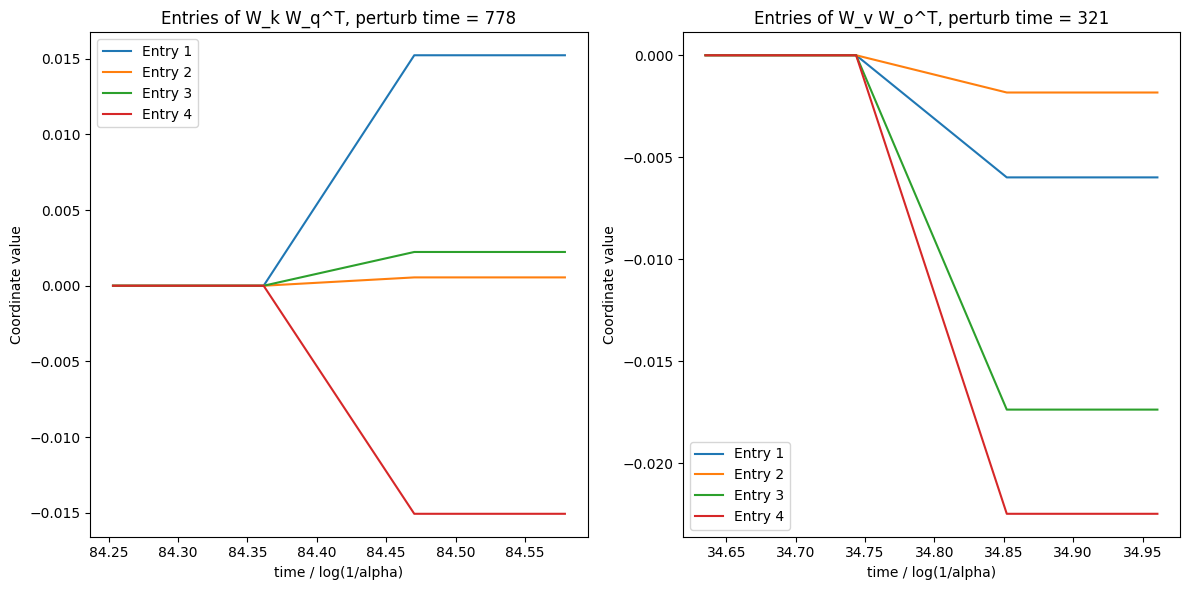

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Model Parameters
d_model = 4  # Number of dimensions
n_iters = 1000
alpha = 1e-4  # Small initialization scale
learning_rate = 0.1

# Synthetic Data
n_samples = 10
X = torch.randn(n_samples, d_model)
y = torch.randn(n_samples, d_model)  # Dummy target

# Loss function
loss_fn = nn.MSELoss()

# Initialize weights
def initialize_weights(alpha):
    w_k = torch.randn(d_model, requires_grad=True) * alpha
    w_q = torch.randn(d_model, requires_grad=True) * alpha
    w_v = torch.randn(d_model, requires_grad=True) * alpha
    w_o = torch.randn(d_model, requires_grad=True) * alpha
    return [
        w.clone().detach().requires_grad_(True) for w in [w_k, w_q, w_v, w_o]
    ]

# Experiment 1: Perturbation During Training (Assumption 4.4)
def experiment_perturb_during_training(n_iters, perturb_time):
    w_k, w_q, w_v, w_o = initialize_weights(alpha)
    optimizer = torch.optim.SGD([w_k, w_q, w_v, w_o], lr=learning_rate)
    diag_evolution = []

    for t in range(n_iters):
        optimizer.zero_grad()

        # Compute model output
        attention_scores = (X * w_q) @ (X * w_k).T
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attention_output = attention_weights @ (X * w_v) * w_o

        # Compute loss
        loss = loss_fn(attention_output, y)
        loss.backward()
        optimizer.step()

        # Perturb weights at perturb_time
        if t == perturb_time:
            w_k.data += torch.randn_like(w_k) * 0.1
            w_q.data += torch.randn_like(w_q) * 0.1

        # Store diagonal entries of W_W^T
        diag_evolution.append((w_k.detach().clone(), w_q.detach().clone()))

    return diag_evolution

# Experiment 2: Perturbation at Stage Start (Assumption 4.5)
def experiment_perturb_stage_start(n_iters, perturb_stage):
    w_k, w_q, w_v, w_o = initialize_weights(alpha)
    optimizer = torch.optim.SGD([w_k, w_q, w_v, w_o], lr=learning_rate)
    diag_evolution = []

    for t in range(n_iters):
        optimizer.zero_grad()

        # Compute model output
        attention_scores = (X * w_q) @ (X * w_k).T
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attention_output = attention_weights @ (X * w_v) * w_o

        # Compute loss
        loss = loss_fn(attention_output, y)
        loss.backward()
        optimizer.step()

        # Perturb at the start of a new stage
        if t == perturb_stage:
            w_k.data += torch.randn_like(w_k) * 0.1
            w_q.data += torch.randn_like(w_q) * 0.1

        # Store diagonal entries of W_W^T
        diag_evolution.append((w_k.detach().clone(), w_q.detach().clone()))

    return diag_evolution

# Run Experiments
perturb_time = 778
diag_evolution_44 = experiment_perturb_during_training(n_iters, perturb_time)

perturb_stage = 321
diag_evolution_45 = experiment_perturb_stage_start(n_iters, perturb_stage)

# Plotting Figure 3(a): Perturbation During Training
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
rescaled_time = [t / torch.log(torch.tensor(1 / alpha)).item() for t in range(n_iters)]
for i in range(d_model):
    plt.plot(
        rescaled_time[perturb_time - 2 : perturb_time + 2],
        [diag[0][i] * diag[1][i] for diag in diag_evolution_44[perturb_time - 2 : perturb_time + 2]],
        label=f"Entry {i+1}",
    )
plt.xlabel("time / log(1/alpha)")
plt.ylabel("Coordinate value")
plt.title(f"Entries of W_k W_q^T, perturb time = {perturb_time}")
plt.legend()

# Plotting Figure 3(b): Perturbation at Stage Start
plt.subplot(1, 2, 2)
for i in range(d_model):
    plt.plot(
        rescaled_time[perturb_stage - 2: perturb_stage + 2],
        [diag[0][i] * diag[1][i] for diag in diag_evolution_45[perturb_stage - 2 : perturb_stage + 2]],
        label=f"Entry {i+1}",
    )
plt.xlabel("time / log(1/alpha)")
plt.ylabel("Coordinate value")
plt.title(f"Entries of W_v W_o^T, perturb time = {perturb_stage}")
plt.legend()

plt.tight_layout()
plt.show()


## Fig 4
eNet (d) GPT-2, Wikitext-103
Figure 4: Stable rank of ∆WKW⊤
Q (blue) and ∆WV W⊤
O(orange) on an arbitrary chosen layer
throughout training for four different pairs of networks and tasks. The stable rank of a matrix W
is defined as ∥W∥2F/∥W∥22, and gives a smooth approximation of the rank. Mean and standard
deviation (shaded area) are computed ac

### CIFAR10 data


In [2]:
import numpy as np

import torch
from transformers import ViTForImageClassification, ViTConfig
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



# Vision Transformer model
config = ViTConfig(image_size=224, num_labels=1000, hidden_size=128, num_attention_heads=4)
model = ViTForImageClassification(config)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
# Stable rank calculation function
def stable_rank(matrix):
    """Calculate the stable rank of a matrix W as ||W||_F^2 / ||W||_2^2."""
    frobenius_norm = torch.norm(matrix, p='fro')  # Frobenius norm
    spectral_norm = torch.linalg.norm(matrix, ord=2)  # Spectral norm
    return (frobenius_norm ** 2) / (spectral_norm ** 2)

# Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()



# Define the layer and parameter names
layer_idx = 3  # Change to the layer index you want to analyze (e.g., 0, 1, 2,...)
#Extract the key, query, value, and output weights for a specific layer in the ViT model
key_weight_name = f"vit.encoder.layer.{layer_idx}.attention.attention.key.weight"
query_weight_name = f"vit.encoder.layer.{layer_idx}.attention.attention.query.weight"
value_weight_name = f"vit.encoder.layer.{layer_idx}.attention.attention.value.weight"
output_weight_name = f"vit.encoder.layer.{layer_idx}.attention.output.dense.weight"

# Now extract the actual weights from the model (assuming `model` is your loaded ViT model)
W_K = model.state_dict()[key_weight_name]
W_Q = model.state_dict()[query_weight_name]
W_V = model.state_dict()[value_weight_name]
W_O = model.state_dict()[output_weight_name]

# You can also clone them if you want to keep the initial values
W_K_init = W_K.clone()
W_Q_init = W_Q.clone()
W_V_init = W_V.clone()
W_O_init = W_O.clone()

num_epochs=35
iteration = 0  # Global iteration counter


# CIFAR-10 dataset and dataloader
dataloader = DataLoader(cifar10_train, batch_size=32, shuffle=True)

# Training loop with stable rank tracking
iterations = []
stable_ranks_kq = []
stable_ranks_vo = []

# During training, extract current weights
for epoch in range(num_epochs):
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        # Forward and backward pass
        outputs = model(images)
        loss = loss_fn(outputs.logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment the global iteration counter
        iteration += 1
        if iteration % 100 == 0:
           iterations.append(len(iterations) * 100)
           current_key = model.state_dict()[key_weight_name]
           current_query = model.state_dict()[query_weight_name]
           W_V = model.state_dict()[value_weight_name]
           W_O = model.state_dict()[output_weight_name]
           # Compute perturbation
           initial_key = W_K_init
           initial_query = W_Q_init
           perturbation = (current_key @ current_query.T) - (initial_key @ initial_query.T)
           stable_ranks_kq.append(stable_rank(perturbation))
           perturbation = (W_V @ W_O.T) - (W_V_init @ W_O_init.T)
           # Compute and store singular values
           stable_ranks_vo.append(stable_rank(perturbation))
    print(f"Epoch {epoch+1}: Loss = {loss.item()}")



Epoch 1: Loss = 1.777919888496399
Epoch 2: Loss = 1.4477297067642212
Epoch 3: Loss = 1.5646666288375854
Epoch 4: Loss = 1.0548887252807617
Epoch 5: Loss = 1.1162728071212769
Epoch 6: Loss = 1.1724168062210083
Epoch 7: Loss = 1.346935510635376
Epoch 8: Loss = 1.4885367155075073
Epoch 9: Loss = 0.7348861694335938
Epoch 10: Loss = 0.9610248804092407
Epoch 11: Loss = 0.9211822152137756
Epoch 12: Loss = 0.9123298525810242
Epoch 13: Loss = 0.8832507133483887
Epoch 14: Loss = 0.5367015600204468
Epoch 15: Loss = 0.8487412333488464
Epoch 16: Loss = 0.7820629477500916
Epoch 17: Loss = 0.6254388689994812
Epoch 18: Loss = 0.8789377808570862
Epoch 19: Loss = 0.7855027914047241
Epoch 20: Loss = 0.833946168422699
Epoch 21: Loss = 0.5688664317131042
Epoch 22: Loss = 0.547173261642456
Epoch 23: Loss = 0.706520676612854
Epoch 24: Loss = 0.8765647411346436
Epoch 25: Loss = 0.33934009075164795
Epoch 26: Loss = 0.3608420193195343
Epoch 27: Loss = 0.3815135657787323
Epoch 28: Loss = 0.8339871168136597
Epoch

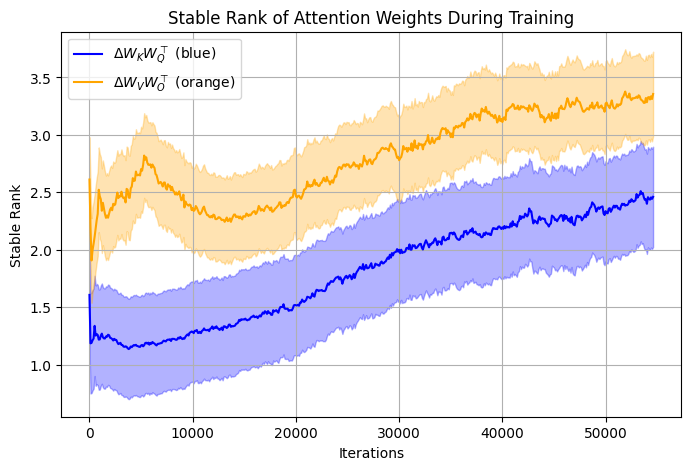

In [3]:
# Move tensors to CPU and convert them to NumPy arrays
# Convert each tensor in the list to a NumPy array after moving it to the CPU
stable_ranks_kq = [rank.cpu().item() for rank in stable_ranks_kq]
stable_ranks_vo = [rank.cpu().item() for rank in stable_ranks_vo]

# Plotting stable ranks
plt.figure(figsize=(8, 5))
plt.plot(iterations, stable_ranks_kq, label=r"$\Delta W_K W_Q^\top$ (blue)", color='blue')
plt.plot(iterations, stable_ranks_vo, label=r"$\Delta W_V W_O^\top$ (orange)", color='orange')
plt.fill_between(iterations,
                 np.array(stable_ranks_kq) - np.std(stable_ranks_kq),
                 np.array(stable_ranks_kq) + np.std(stable_ranks_kq),
                 color='blue', alpha=0.3)
plt.fill_between(iterations,
                 np.array(stable_ranks_vo) - np.std(stable_ranks_vo),
                 np.array(stable_ranks_vo) + np.std(stable_ranks_vo),
                 color='orange', alpha=0.3)
plt.xlabel("Iterations")
plt.ylabel("Stable Rank")
plt.title("Stable Rank of Attention Weights During Training")
plt.legend()
plt.grid(True)
plt.show()
